# Introduction #

Welcome to the feature engineering project for the [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition! This competition uses nearly the same data which we used in the exercises of the Feature Engineering course.

# Step 1 - Preliminaries #
## 1.1 Imports and Configuration ##

We'll start by importing the packages we used in the exercises and setting some notebook defaults. Unhide this cell if you'd like to see the libraries we'll use:

In [2]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

## 1.2 Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. The data we used in the course was a bit simpler than the competition data. For the *Ames* competition dataset, we'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

Below is an example of the load_data method. We will show how to implement the
- clean
- encode
- impute
method one by one.

```python

def load_data():
    # Read data
    data_dir = Path("../../data/house_price")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test
```

### 1.2.1 Data cleaning

The first thing is to detect anomalies in the dataset. Then check if the anomalies are errors or outliers. If it's an error, we need to correct it. If it's outlier, we can remove it if the models require it.

#### Let's detect the anomalie.

Here we will use data profiling tool to
Some of the categorical features in this dataset have what are apparently typos in their categories:

In [4]:
data_dir = Path("../../data/house_price")

df_train_raw=pd.read_csv(data_dir/"train.csv",index_col="Id")

In [5]:
df_train_raw.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_train_raw, title="House price data profile", minimal=False,explorative=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

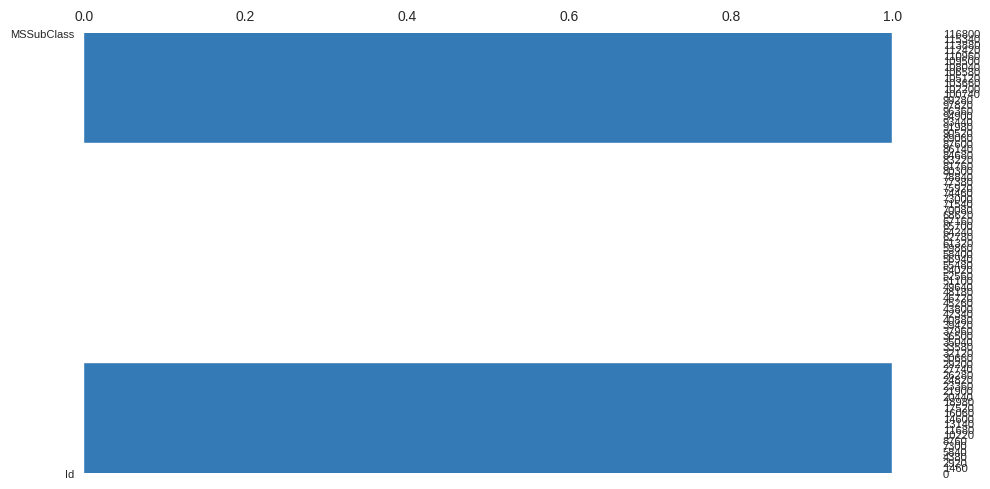

In [8]:
output_dir="/tmp/data_profiling"
Path(output_dir).mkdir(parents=True, exist_ok=True)
# export the report in html format
output_html_file_path=f"{output_dir}/house_price_report.html"

profile.to_file(output_html_file_path)

Comparing the generated report to `data_description.txt` shows us several anomalies. For example in column `Exterior2nd`, it suppose to contain following distinct values

```text
AsbShng	Asbestos Shingles
AsphShn	Asphalt Shingles
BrkComm	Brick Common
BrkFace	Brick Face
CBlock	Cinder Block
CemntBd	Cement Board
HdBoard	Hard Board
ImStucc	Imitation Stucco
MetalSd	Metal Siding
Other	Other
Plywood	Plywood
PreCast	PreCast
Stone	Stone
Stucco	Stucco
VinylSd	Vinyl Siding
Wd Sdng	Wood Siding
WdShing	Wood Shingles
```
But, in the training dataset, we find a value `Brk Cmn` that does not exist. And we know it's a typo of `BrkComm`.


In [9]:
df_train_raw.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [ ]:
df_train_raw["Exterior2nd"] = df_train_raw["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})

We also find the `GarageYrBlt` column has many `NaN` value. We need to impute these NaN. And the `YearBuild` is a good candidate to impute the `GarageYrBlt`.

In [10]:
df_train_raw["GarageYrBlt"].unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

In [ ]:
df_train_raw.YearBuilt.unique()

In [16]:
# replace NaN by the YearBuilt column value
df_train_raw["GarageYrBlt"] = df_train_raw["GarageYrBlt"].where(df_train_raw.GarageYrBlt <= 2010, df_train_raw.YearBuilt)

Column Names (e.g. 1stFlrSF, 2ndFlrSF) beginning with numbers are awkward to work with. So we need to rename these columns.

In [ ]:

df_train_raw.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )

Note there are many other problem that needs to be cleaned. You can find them by yourself. Based on the above work, we can write the clean() method as below.

In [ ]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

### 1.2.2 Encode the Statistical Data Type ###

Pandas has Python types corresponding to the standard statistical types (numeric, categorical, etc.). Encoding each feature with its correct type helps ensure each feature is treated appropriately by whatever functions we use, and makes it easier for us to apply transformations consistently. This hidden cell defines the `encode` function: